In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt
from scikitplot.helpers import binary_ks_curve


import optuna
from optuna.trial import TrialState

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [3]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

## Declarando as funções de avaliação do modelo

In [4]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [5]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [7]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [8]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [9]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [10]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [11]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [12]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo da Random Forest

In [13]:
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=df_train.shape[1]
)

In [14]:
model.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=10, max_features=35, n_estimators=10)

## Avaliando o modelo

### Conjunto de Validação

In [15]:
y_pred_val_class = model.predict(X_val)
y_pred_val_scores = model.predict_proba(X_val)

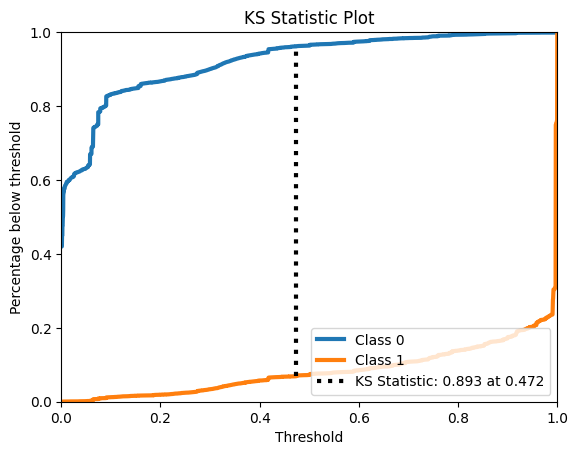



Random Forest - Validation

Accuracy:         0.9456
Recall:           0.9276
Precision:        0.9622
F1:               0.9446
AUROC:            0.9895
AUPR:             0.9897


In [16]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_val_class, y_pred_val_scores)
print('\n\nRandom Forest - Validation')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

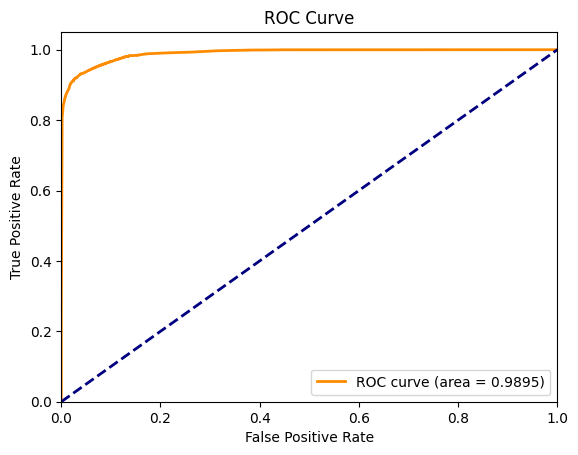

In [17]:
plot_roc_curve(y_pred_val_scores, y_val)

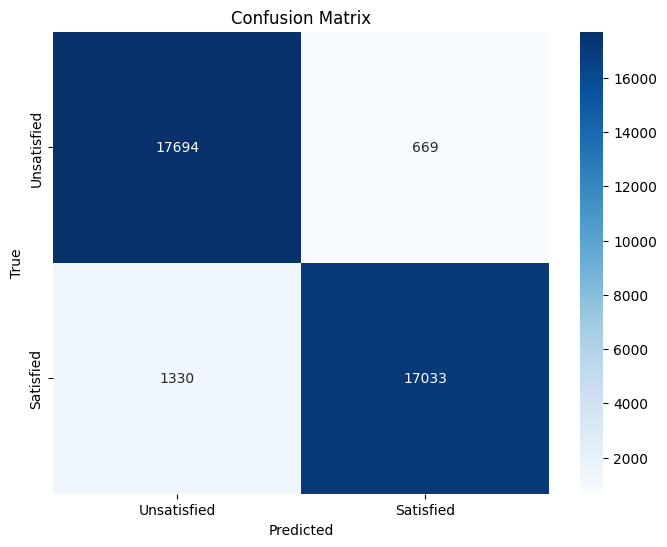

In [18]:
plot_confusion_matrix(y_pred=y_pred_val_class, y_test=y_val)

### Conjunto de Teste

In [19]:
y_pred_test_class = model.predict(X_test)
y_pred_test_scores = model.predict_proba(X_test)

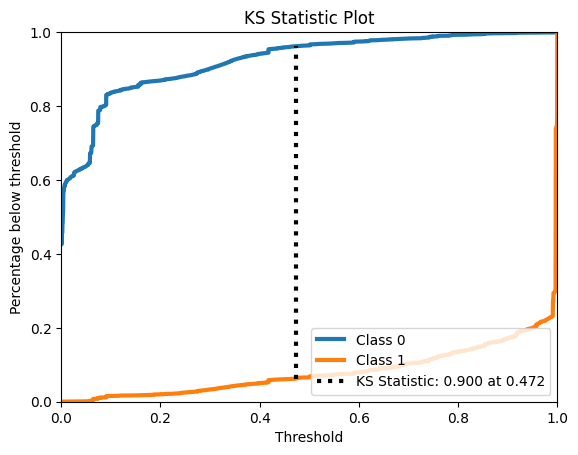



Random Forest - Test

Accuracy:         0.9511
Recall:           0.9342
Precision:        0.9523
F1:               0.9432
AUROC:            0.9899
AUPR:             0.9875


In [20]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
print('\n\nRandom Forest - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

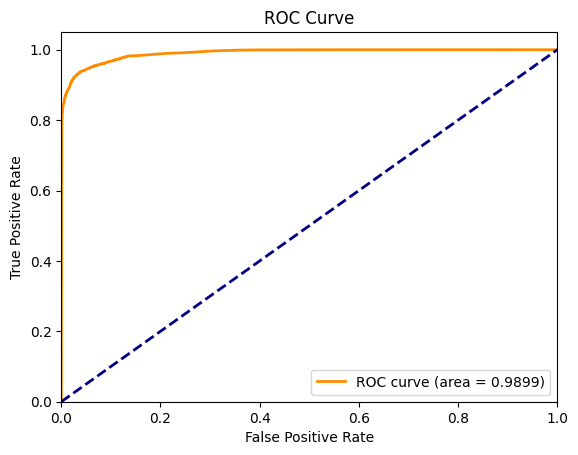

In [21]:
plot_roc_curve(y_pred_test_scores, y_test)

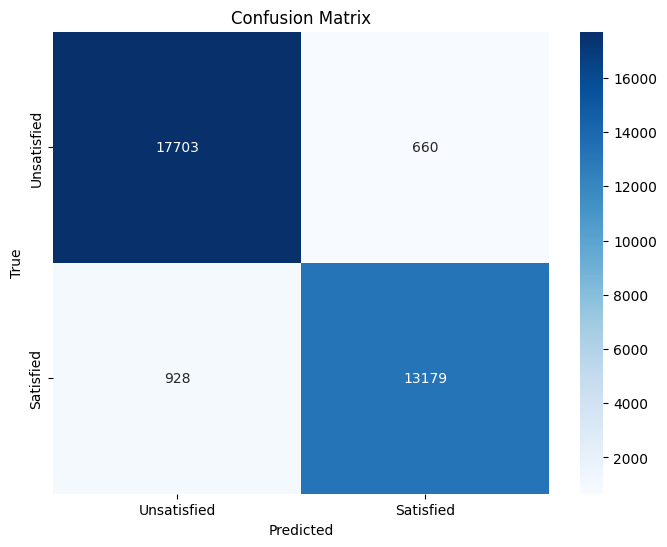

In [22]:
plot_confusion_matrix(y_pred=y_pred_test_class, y_test=y_test)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [23]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    y_pred_test_scores = model.predict_proba(X_test)

    thresholds, pct1, pct2, ks_statistic, \
        max_distance_at, classes = binary_ks_curve(y_test, y_pred_test_scores[:, 1].ravel())

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_test_class, y_pred_test_scores)
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    trial.set_user_attr("ks_statistic", ks_statistic)
    trial.set_user_attr("max_distance_at", max_distance_at)
    
    return auroc, ks_statistic


[I 2024-07-17 21:11:41,246] A new study created in memory with name: no-name-36a09ada-d756-4a34-a228-367390c5b059


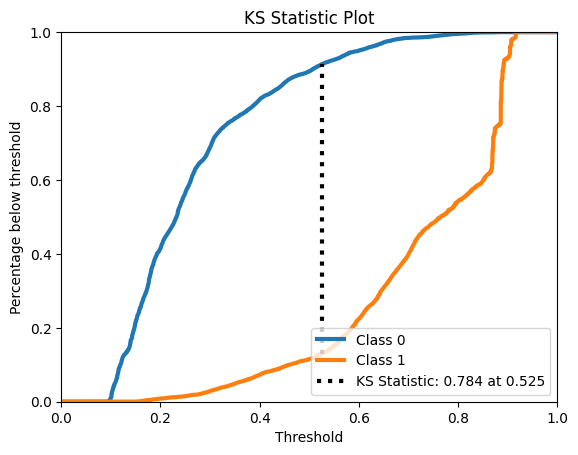

[I 2024-07-17 21:11:42,880] Trial 0 finished with values: [0.9551620724068202, 0.783744465735446] and parameters: {'n_estimators': 86, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 9}. 




Random Forest
n_estimators: 86
max_depth:3
min_samples_split:8
min_samples_leaf:9

Accuracy:         0.8899
Recall:           0.8845
Precision:        0.8650
F1:               0.8747
AUROC:            0.9552
AUPR:             0.9471


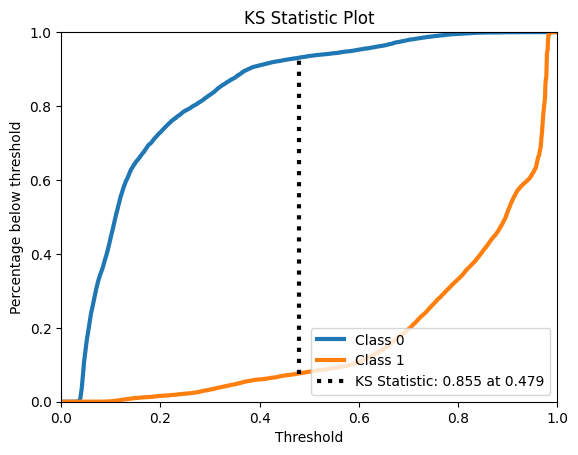

[I 2024-07-17 21:11:47,651] Trial 1 finished with values: [0.9787915614844345, 0.8546194547108953] and parameters: {'n_estimators': 194, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. 




Random Forest
n_estimators: 194
max_depth:6
min_samples_split:9
min_samples_leaf:6

Accuracy:         0.9281
Recall:           0.9187
Precision:        0.9160
F1:               0.9174
AUROC:            0.9788
AUPR:             0.9753


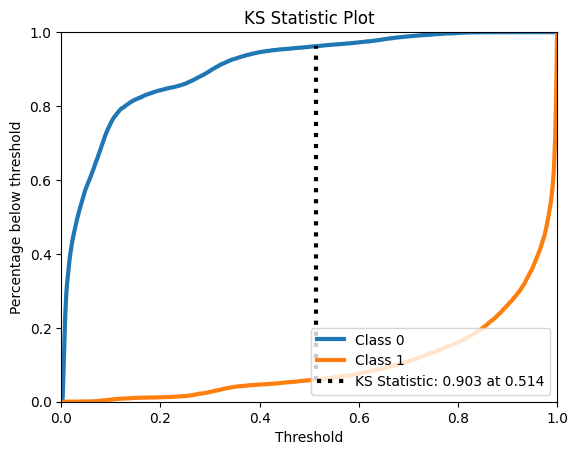

[I 2024-07-17 21:11:52,559] Trial 2 finished with values: [0.9912612503157298, 0.9030870250990631] and parameters: {'n_estimators': 123, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 2}. 




Random Forest
n_estimators: 123
max_depth:12
min_samples_split:15
min_samples_leaf:2

Accuracy:         0.9522
Recall:           0.9419
Precision:        0.9477
F1:               0.9448
AUROC:            0.9913
AUPR:             0.9900


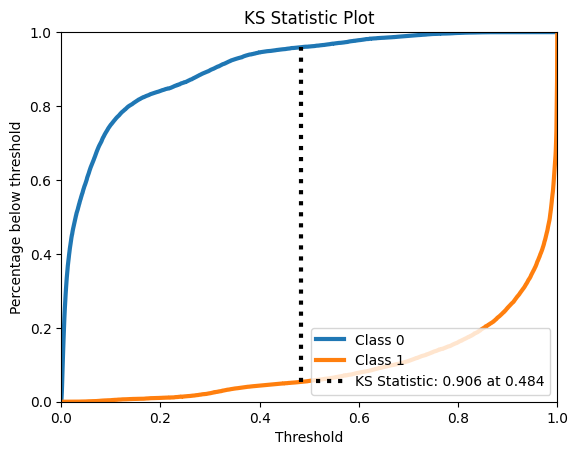

[I 2024-07-17 21:12:01,405] Trial 3 finished with values: [0.9920528658367231, 0.9058553005091461] and parameters: {'n_estimators': 209, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 9}. 




Random Forest
n_estimators: 209
max_depth:16
min_samples_split:3
min_samples_leaf:9

Accuracy:         0.9536
Recall:           0.9438
Precision:        0.9491
F1:               0.9464
AUROC:            0.9921
AUPR:             0.9908


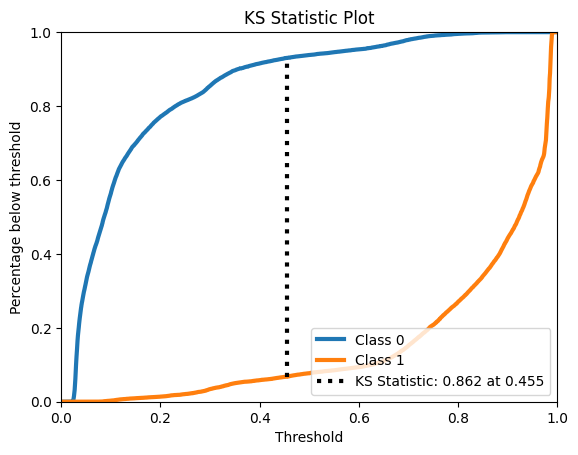

[I 2024-07-17 21:12:05,793] Trial 4 finished with values: [0.9830544102253693, 0.8624888114346857] and parameters: {'n_estimators': 160, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 10}. 




Random Forest
n_estimators: 160
max_depth:7
min_samples_split:7
min_samples_leaf:10

Accuracy:         0.9316
Recall:           0.9229
Precision:        0.9198
F1:               0.9214
AUROC:            0.9831
AUPR:             0.9805


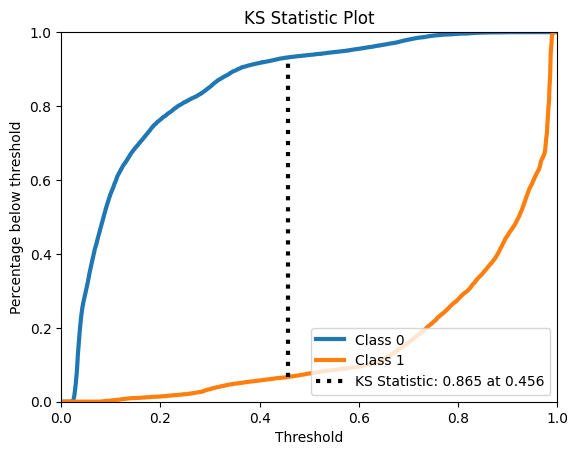

[I 2024-07-17 21:12:11,202] Trial 5 finished with values: [0.9826503655375594, 0.8649299761196471] and parameters: {'n_estimators': 194, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. 




Random Forest
n_estimators: 194
max_depth:7
min_samples_split:3
min_samples_leaf:3

Accuracy:         0.9318
Recall:           0.9236
Precision:        0.9198
F1:               0.9217
AUROC:            0.9827
AUPR:             0.9801


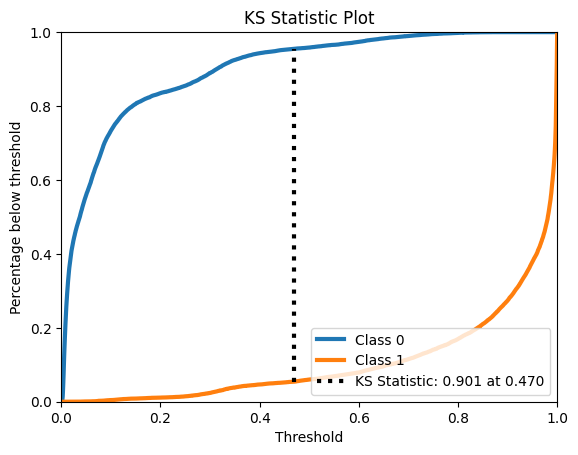

[I 2024-07-17 21:12:25,126] Trial 6 finished with values: [0.9911544337265246, 0.9008607327506457] and parameters: {'n_estimators': 357, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 10}. 




Random Forest
n_estimators: 357
max_depth:13
min_samples_split:10
min_samples_leaf:10

Accuracy:         0.9503
Recall:           0.9400
Precision:        0.9453
F1:               0.9426
AUROC:            0.9912
AUPR:             0.9899


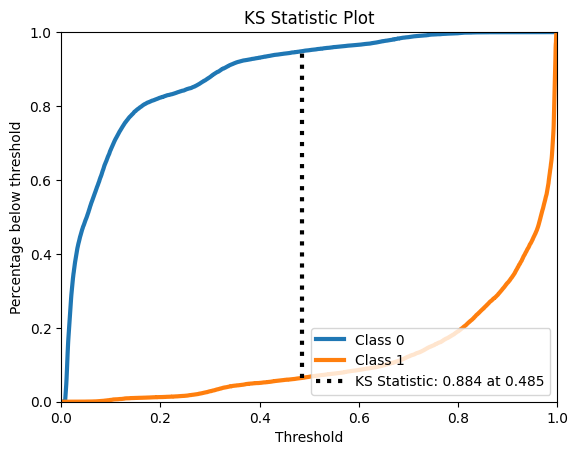

[I 2024-07-17 21:12:34,743] Trial 7 finished with values: [0.9887748177558359, 0.8843801032879609] and parameters: {'n_estimators': 266, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 10}. 




Random Forest
n_estimators: 266
max_depth:10
min_samples_split:3
min_samples_leaf:10

Accuracy:         0.9431
Recall:           0.9327
Precision:        0.9361
F1:               0.9344
AUROC:            0.9888
AUPR:             0.9872


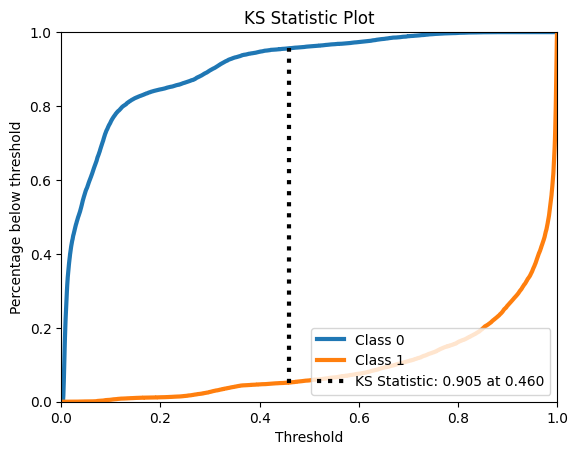

[I 2024-07-17 21:12:52,691] Trial 8 finished with values: [0.9914350219773572, 0.9047412317218723] and parameters: {'n_estimators': 473, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2}. 




Random Forest
n_estimators: 473
max_depth:12
min_samples_split:2
min_samples_leaf:2

Accuracy:         0.9531
Recall:           0.9424
Precision:        0.9493
F1:               0.9458
AUROC:            0.9914
AUPR:             0.9902


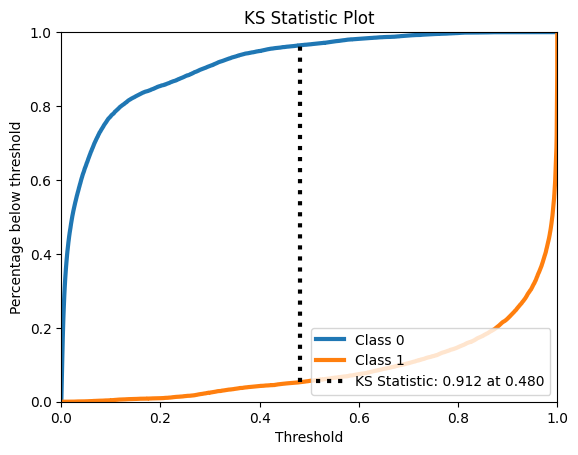

[I 2024-07-17 21:13:13,575] Trial 9 finished with values: [0.9929635080938894, 0.9118958181003257] and parameters: {'n_estimators': 480, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 5}. 




Random Forest
n_estimators: 480
max_depth:18
min_samples_split:10
min_samples_leaf:5

Accuracy:         0.9568
Recall:           0.9439
Precision:        0.9561
F1:               0.9499
AUROC:            0.9930
AUPR:             0.9919


In [24]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [26]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['values_0', 'values_1']) 

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [27]:
df_existing

,number,values_0,values_1,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,user_attrs_accuracy,user_attrs_auroc,user_attrs_f1,user_attrs_ks_statistic,user_attrs_max_depth,user_attrs_max_distance_at,user_attrs_min_samples_leaf,user_attrs_min_samples_split,user_attrs_n_estimators,user_attrs_precision,user_attrs_recall,system_attrs_nsga2:generation
0,0,0.955162,0.783744,3,9,8,86,0.889868,0.955162,0.865026,0.783744,3,0.525407,9,8,86,0.865026,0.884525,0
1,1,0.978792,0.854619,6,6,9,194,0.928087,0.978792,0.916031,0.854619,6,0.479306,6,9,194,0.916031,0.918693,0
5,5,0.982650,0.864930,7,3,3,194,0.931814,0.982650,0.919802,0.864930,7,0.456465,3,3,194,0.919802,0.923584,0
4,4,0.983054,0.862489,7,10,7,160,0.931568,0.983054,0.919816,0.862489,7,0.454593,10,7,160,0.919816,0.922946,0
7,7,0.988775,0.884380,10,10,3,266,0.943086,0.988775,0.936108,0.884380,10,0.484524,10,3,266,0.936108,0.932658,0
6,6,0.991154,0.900861,13,10,10,357,0.950293,0.991154,0.945320,0.900861,13,0.469530,10,10,357,0.945320,0.939959,0
2,2,0.991261,0.903087,12,2,15,123,0.952202,0.991261,0.947721,0.903087,12,0.513775,2,15,123,0.947721,0.941944,0
8,8,0.991435,0.904741,12,2,2,473,0.953095,0.991435,0.949300,0.904741,12,0.459703,2,2,473,0.949300,0.942369,0
3,3,0.992053,0.905855,16,9,3,209,0.953588,0.992053,0.949102,0.905855,16,0.484260,9,3,209,0.949102,0.943787,0
9,9,0.992964,0.911896,18,5,10,480,0.956760,0.992964,0.956057,0.911896,18,0.480319,5,10,480,0.956057,0.943858,0


In [31]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")
print(f"  ks_statistic:  {best_trial.user_attrs['ks_statistic']}")
print(f"  max_distance_at:  {best_trial.user_attrs['max_distance_at']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9567600862334462
  Precision: 0.9560565807424427
  Recall:    0.9438576593180691
  F1 Score:  0.9560565807424427
  auroc:  0.9929635080938894
  ks_statistic:  0.9118958181003257
  max_distance_at:  0.4803185620201714
  Parameters: 
    n_estimators:     480
    max_depth:        18
    min_samples_split: 10
    min_samples_leaf: 5

-- Overall Results (Ordered by auroc) --
   number  values_0  values_1  params_max_depth  params_min_samples_leaf  \
0       0  0.955162  0.783744                 3                        9   
1       1  0.978792  0.854619                 6                        6   
5       5  0.982650  0.864930                 7                        3   
4       4  0.983054  0.862489                 7                       10   
7       7  0.988775  0.884380                10                       10   
6       6  0.991154  0.900861                13                       10   
2       2  0.991261  0.903087                12             